# I am following the kaggle submission to a contest at the following link

# https://www.kaggle.com/code/ekrembayar/store-item-demand-forecasting-with-lgbm/notebook

In [3]:
# Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model
import lightgbm as lgb
import shap
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


In [5]:
train = pd.read_csv('data/train.csv', parse_dates=['date'])
test = pd.read_csv('data/test.csv', parse_dates=['date'])

In [6]:
# creating a dataframe by concatenating the train and test data
df = pd.concat([train, test], sort = False)

In [8]:
print(train.shape, test.shape, df.shape, "\n")
train.head(5)

(913000, 4) (45000, 4) (958000, 5) 



,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [52]:
train.item.count(), test.item.count(), df.item.count()

(913000, 45000, 958000)

In [49]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


# Exploratory Data Analysis

In [12]:
# Let's check the number of stores and items in the data
train.store.nunique(), test.store.nunique(), train.item.nunique(), test.item.nunique()

(10, 10, 50, 50)

In [14]:
# Time change
train.date.min(), train.date.max(), test.date.min(), test.date.max()

(Timestamp('2013-01-01 00:00:00'),
 Timestamp('2017-12-31 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-03-31 00:00:00'))

In [15]:
# Number of Items in the store
df.groupby(['store'])['item'].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [40]:
df.shape

(958000, 5)

In [47]:
df.shape

(958000, 5)

In [53]:
# summary statistics for each store
df.groupby(['store']).agg({'sales': ['count', 'sum', 'mean', 'median', 'std', 'min', 'max']})

sales                                                    
       count        sum       mean median        std  min    max
store                                                           
1      91300  4315603.0  47.268379   44.0  24.006252  1.0  155.0
2      91300  6120128.0  67.033165   62.0  33.595810  3.0  231.0
3      91300  5435144.0  59.530602   55.0  29.974102  3.0  196.0
4      91300  5012639.0  54.902946   51.0  27.733097  4.0  186.0
5      91300  3631016.0  39.770164   37.0  20.365757  2.0  130.0
6      91300  3627670.0  39.733516   37.0  20.310451  0.0  134.0
7      91300  3320009.0  36.363735   34.0  18.684825  1.0  122.0
8      91300  5856169.0  64.142048   60.0  32.231751  4.0  204.0
9      91300  5025976.0  55.049025   51.0  27.832186  4.0  195.0
10     91300  5360158.0  58.709288   54.0  29.554994  3.0  187.0

In [20]:
# Summary Stats for each item
df.groupby(['item']).agg({'sales': ['count', 'sum', 'mean', 'median', 'std', 'min', 'max']})

sales                                                     
      count        sum       mean median        std   min    max
item                                                            
1     18260   401384.0  21.981599   21.0   8.468922   1.0   59.0
2     18260  1069564.0  58.574151   56.0  20.093015   9.0  150.0
3     18260   669087.0  36.642223   35.0  13.179441   7.0  104.0
4     18260   401907.0  22.010241   21.0   8.403898   0.0   66.0
5     18260   335230.0  18.358708   18.0   7.265167   1.0   50.0
6     18260  1068281.0  58.503888   56.0  20.174898  11.0  148.0
7     18260  1068777.0  58.531051   56.0  20.146002  11.0  141.0
8     18260  1405108.0  76.950055   74.0  26.130697  15.0  181.0
9     18260   938379.0  51.389869   49.5  17.790158   6.0  134.0
10    18260  1337133.0  73.227437   70.0  24.823725  14.0  175.0
11    18260  1271925.0  69.656353   67.0  23.744732  11.0  170.0
12    18260  1271534.0  69.634940   67.0  23.738663  12.0  170.0
13    18260  1539621.0  84.316594   81.0  28.311031  20.0  210.0
14    18260  1071531.0  58.681873   56.0  20.079860  12.0  152.0
15    18260  1607442.0  88.030778   85.0  29.522852  17.0  231.0
16    18260   468480.0  25.656079   25.0   9.603270   2.0   70.0
17    18260   602486.0  32.994852   32.0  11.967610   4.0   83.0
18    18260  1538876.0  84.275794   81.0  28.430621  18.0  208.0
19    18260   736892.0  40.355531   39.0  14.332645   5.0   99.0
20    18260   867641.0  47.515936   46.0  16.490487   9.0  127.0
21    18260   736190.0  40.317087   39.0  14.338006   7.0  109.0
22    18260  1469971.0  80.502245   78.0  27.118163  14.0  214.0
23    18260   534979.0  29.297864   28.0  10.819549   3.0   81.0
24    18260  1205975.0  66.044633   64.0  22.531555  14.0  156.0
25    18260  1473334.0  80.686418   78.0  27.238817  18.0  193.0
26    18260   869981.0  47.644085   46.0  16.723912   8.0  119.0
27    18260   402628.0  22.049726   21.0   8.461641   1.0   59.0
28    18260  1604713.0  87.881325   85.0  29.501781  16.0  206.0
29    18260  1271240.0  69.618839   67.0  23.635631  15.0  173.0
30    18260   736554.0  40.337021   39.0  14.363331   5.0  115.0
31    18260  1070845.0  58.644304   57.0  20.104705  10.0  159.0
32    18260   803107.0  43.981763   42.0  15.574556   5.0  119.0
33    18260  1270183.0  69.560953   67.0  23.718343  15.0  169.0
34    18260   469935.0  25.735761   25.0   9.617910   2.0   79.0
35    18260  1201541.0  65.801807   63.0  22.461990  12.0  168.0
36    18260  1406548.0  77.028916   74.0  26.067440  16.0  188.0
37    18260   534258.0  29.258379   28.0  10.771547   3.0   74.0
38    18260  1470330.0  80.521906   77.0  27.141799  15.0  188.0
39    18260   801311.0  43.883406   42.0  15.511550   7.0  112.0
40    18260   534094.0  29.249398   28.0  10.822959   3.0   74.0
41    18260   401759.0  22.002136   21.0   8.402470   2.0   60.0
42    18260   669925.0  36.688116   35.0  13.215112   5.0   96.0
43    18260   936635.0  51.294359   49.0  17.801008   9.0  126.0
44    18260   536811.0  29.398193   28.0  10.797738   3.0   78.0
45    18260  1471467.0  80.584173   78.0  27.318402  18.0  205.0
46    18260  1070764.0  58.639869   56.0  20.220879  11.0  150.0
47    18260   401781.0  22.003341   21.0   8.420102   2.0   61.0
48    18260   937703.0  51.352848   49.0  17.881917   8.0  130.0
49    18260   535663.0  29.335323   28.0  10.874788   3.0   77.0
50    18260  1203009.0  65.882202   63.0  22.416031  12.0  164.0

# Histogram of Store sales

Text(0.5, 0.98, 'Histogram: Sales')

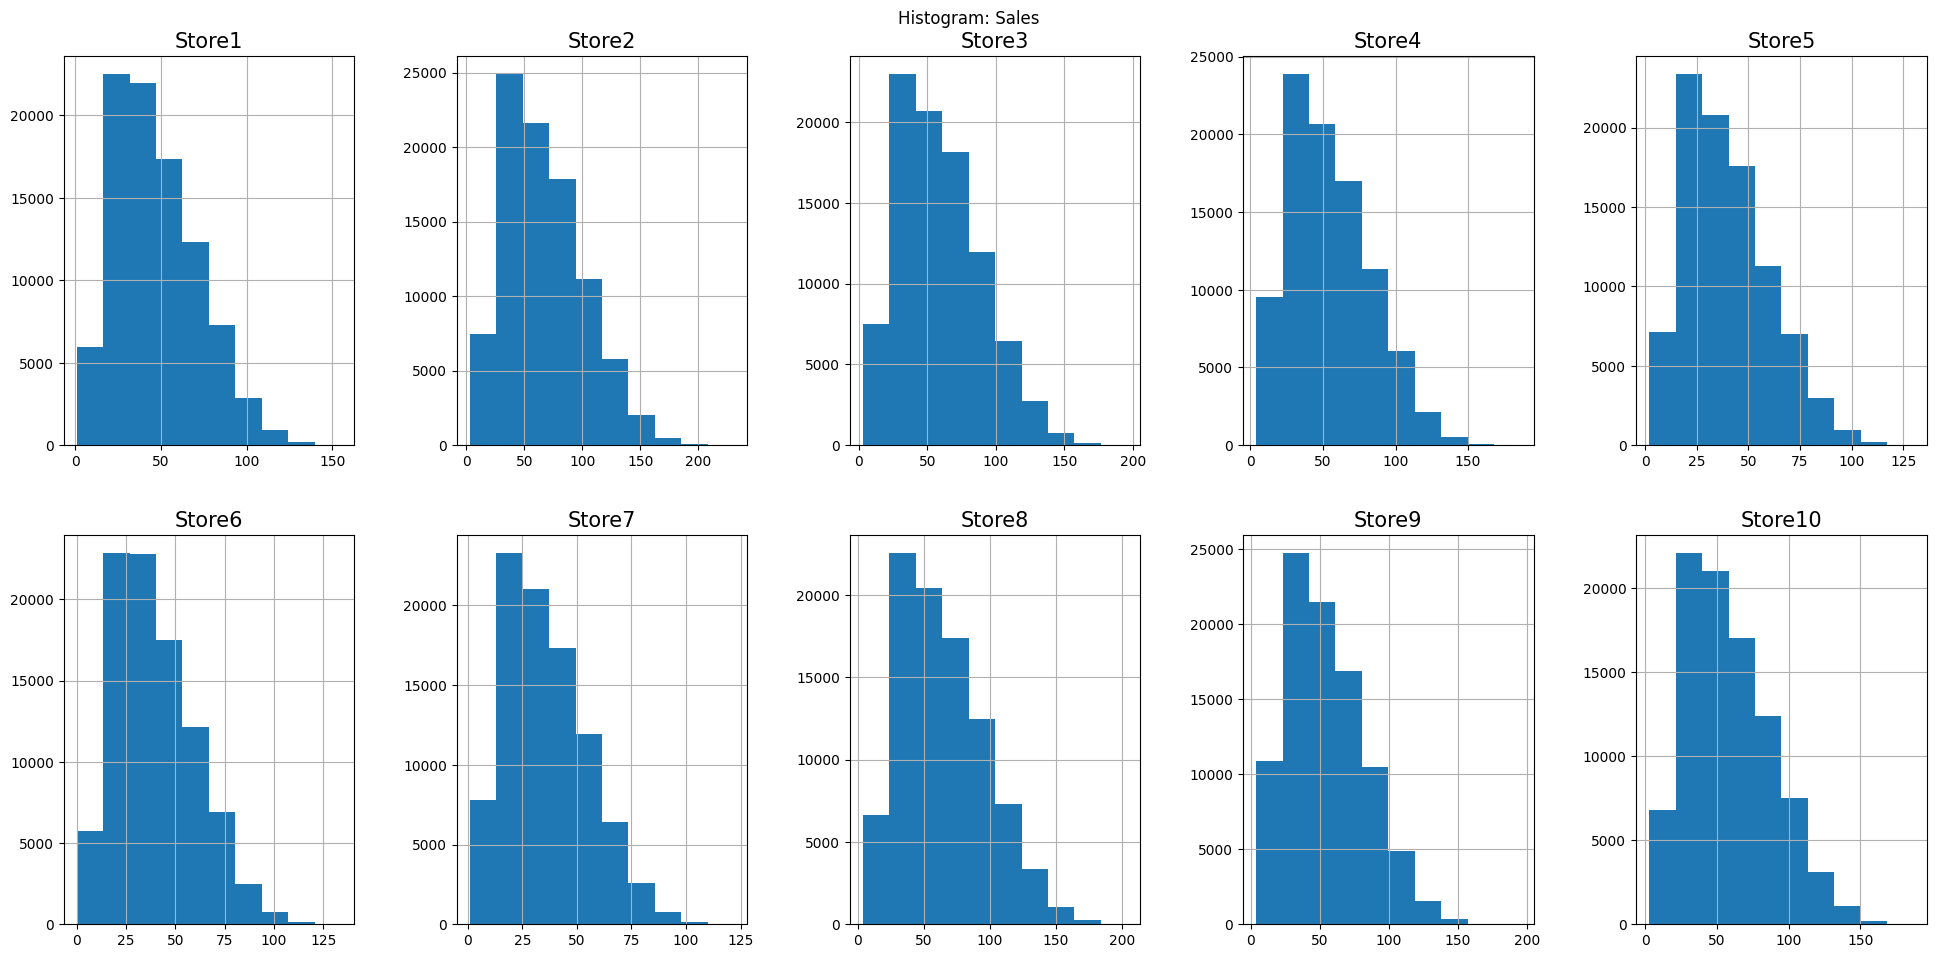

In [72]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))


for i in range(1, 11):
    if i < 6:
        train[train.store == i].sales.hist(ax = axes[0,i - 1])
        axes[0, i-1].set_title('Store' + str(i), fontsize = 15)
    else:
        train[train.store == i].sales.hist(ax = axes[1, i - 6])
        axes[1, i - 6].set_title('Store' + str(i), fontsize = 15)


plt.tight_layout(pad = 3)
plt.suptitle('Histogram: Sales')

# Sales distribution for each item in store 1 training data

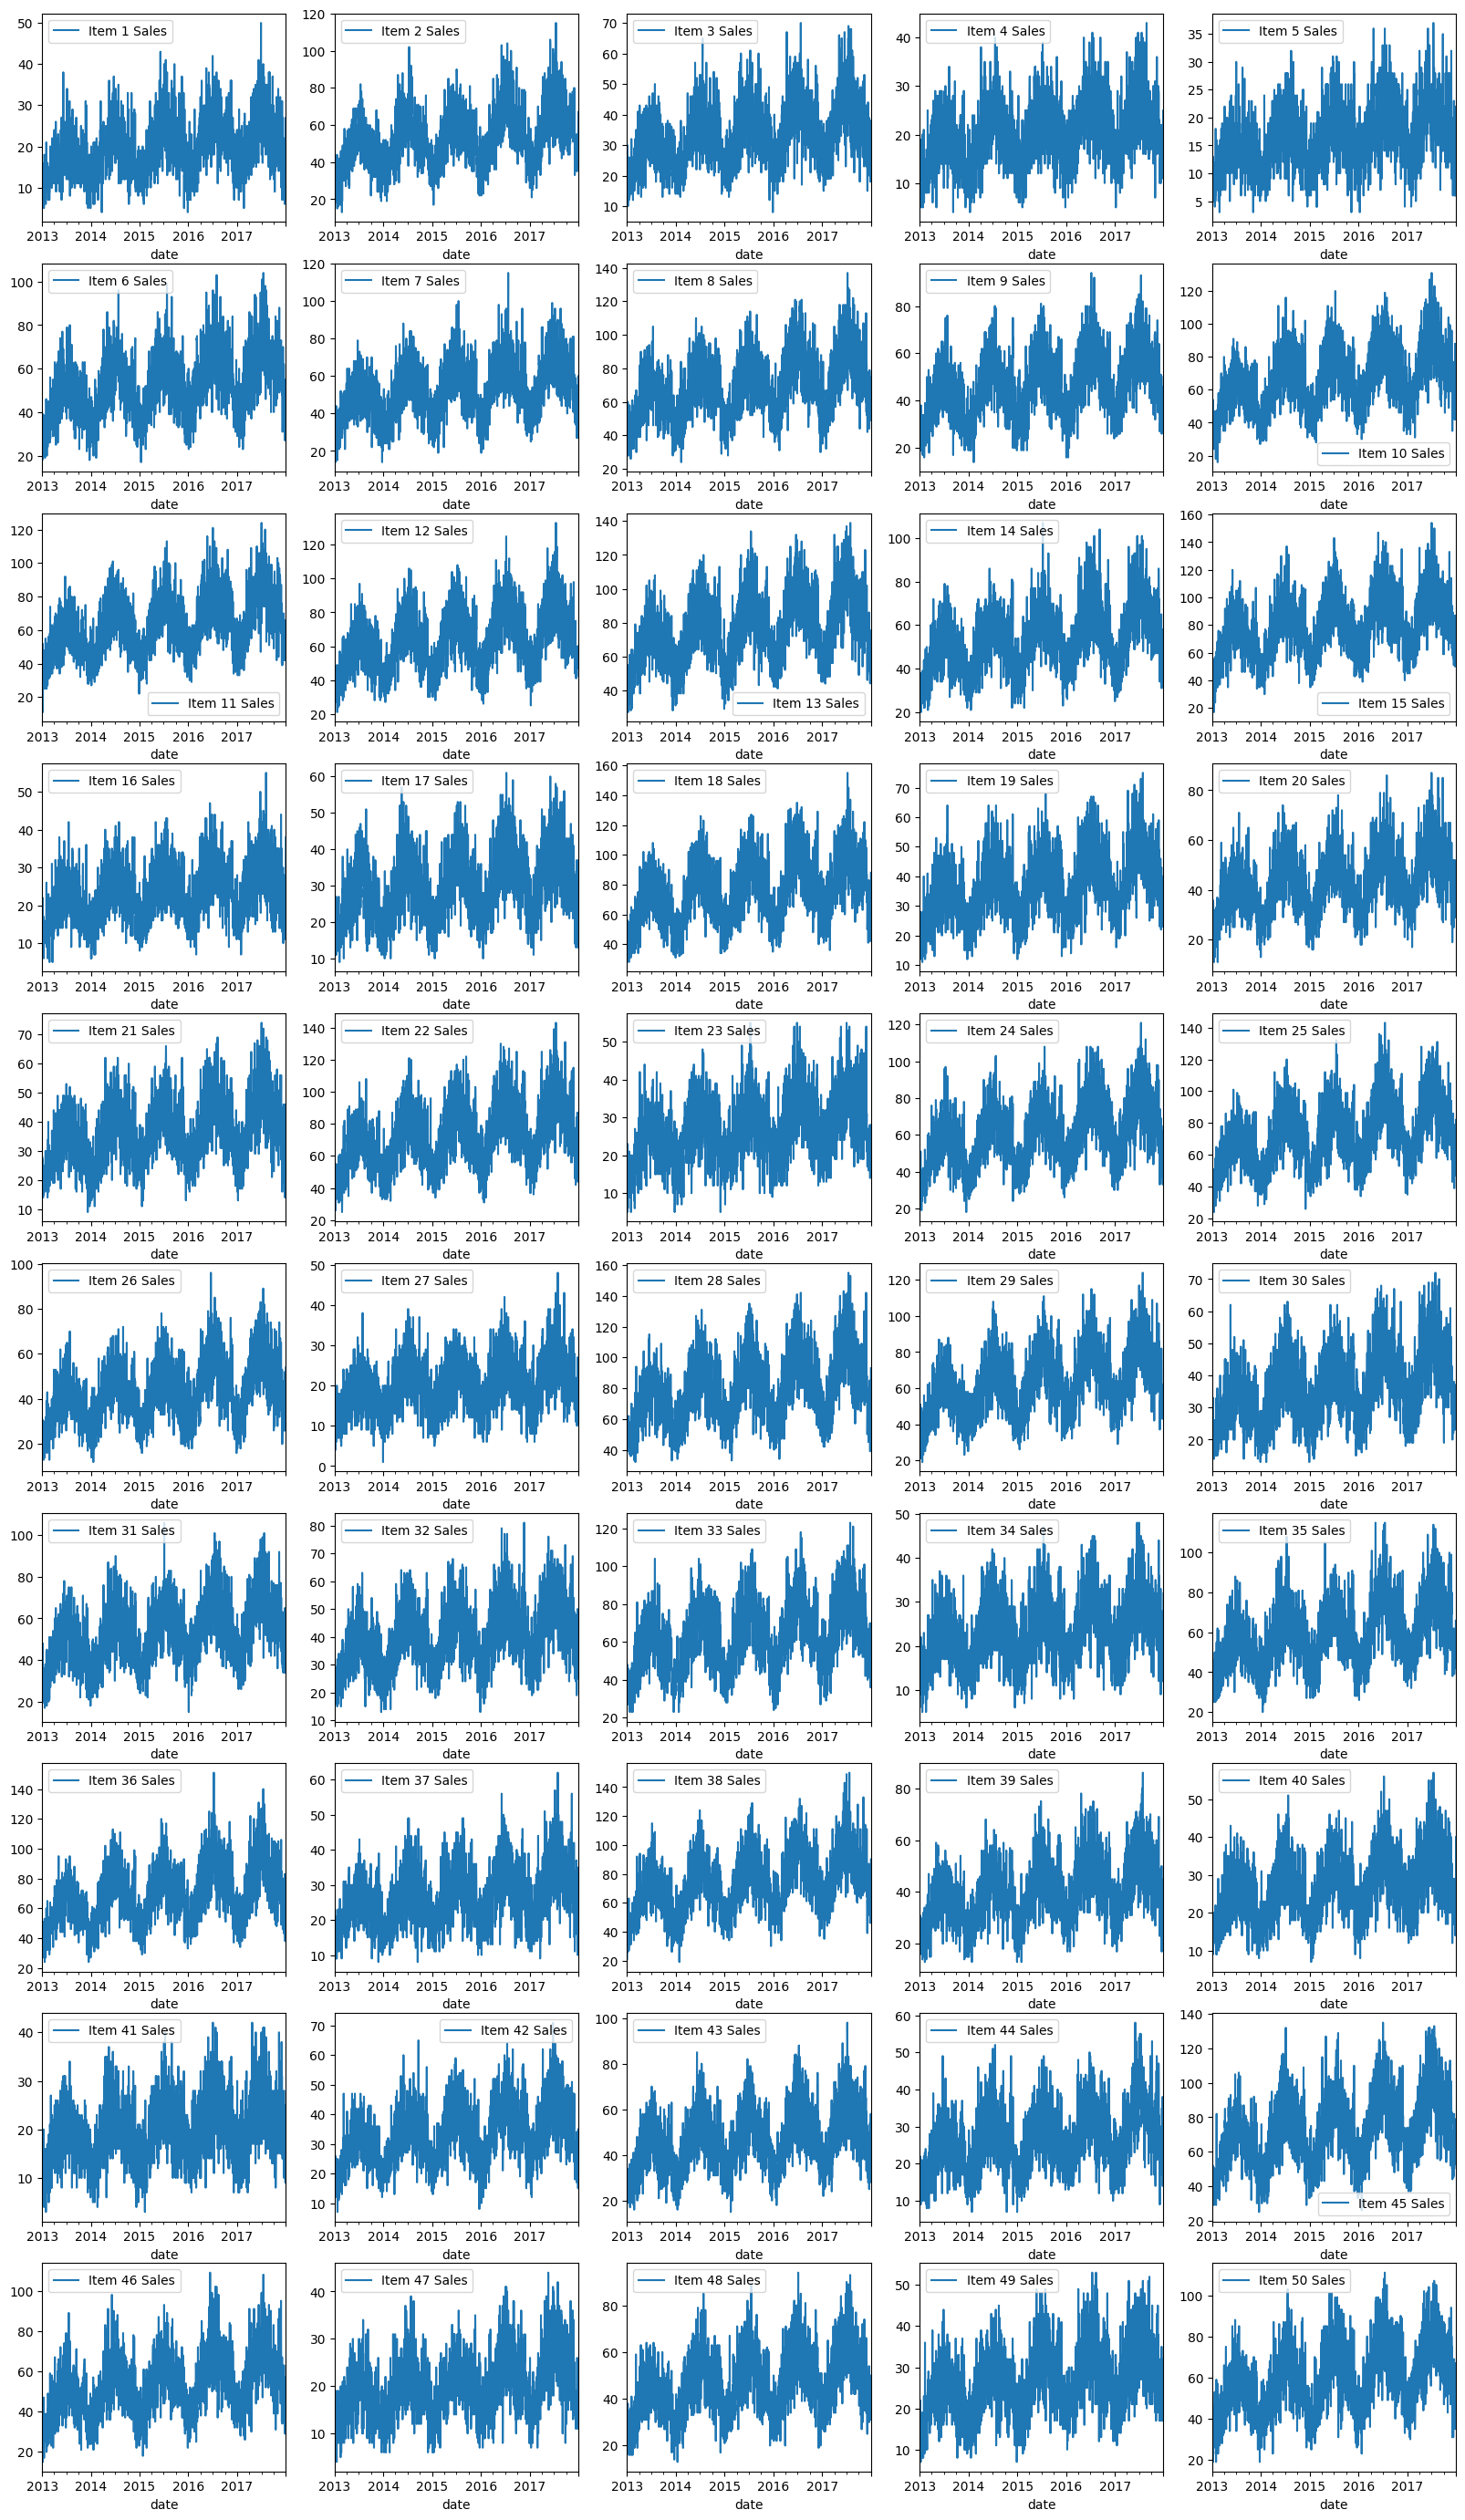

In [97]:
store = 1
sub = train[train.store == store].set_index('date')

fig, axes = plt.subplots(10, 5, figsize = (20, 35))

for i in range(1, 51):
    if i < 6:
        sub[sub.item == i].sales.plot(ax = axes[0, i-1], legend = True, label = 'Item ' + str(i) + ' Sales')
    if i >= 6 and i < 11:
        sub[sub.item == i].sales.plot(ax = axes[1, i-6], legend = True, label = 'Item ' + str(i) + ' Sales')
    if i >= 11 and i < 16:
        sub[sub.item == i].sales.plot(ax = axes[2, i-11], legend = True, label = 'Item ' + str(i) + ' Sales')
    if i >= 16 and i < 21:
        sub[sub.item == i].sales.plot(ax = axes[3, i-16], legend = True, label = 'Item ' + str(i) + ' Sales')
    if i >= 21 and i < 26:
        sub[sub.item == i].sales.plot(ax = axes[4, i-21], legend = True, label = 'Item ' + str(i) + ' Sales')
    if i >= 26 and i < 31:
        sub[sub.item == i].sales.plot(ax = axes[5, i-26], legend = True, label = 'Item ' + str(i) + ' Sales')
    if i >= 31 and i < 36:
        sub[sub.item == i].sales.plot(ax = axes[6, i-31], legend = True, label = 'Item ' + str(i) + ' Sales')
    if i >= 36 and i < 41:
        sub[sub.item == i].sales.plot(ax = axes[7, i-36], legend = True, label = 'Item ' + str(i) + ' Sales')
    if i >= 41 and i < 46:
        sub[sub.item == i].sales.plot(ax = axes[8, i-41], legend = True, label = 'Item ' + str(i) + ' Sales')
    if i >= 46 and i < 51:
        sub[sub.item == i].sales.plot(ax = axes[9, i-46], legend = True, label = 'Item ' + str(i) + ' Sales')

# Correlation between total sales of stores

<Axes: xlabel='store', ylabel='store'>

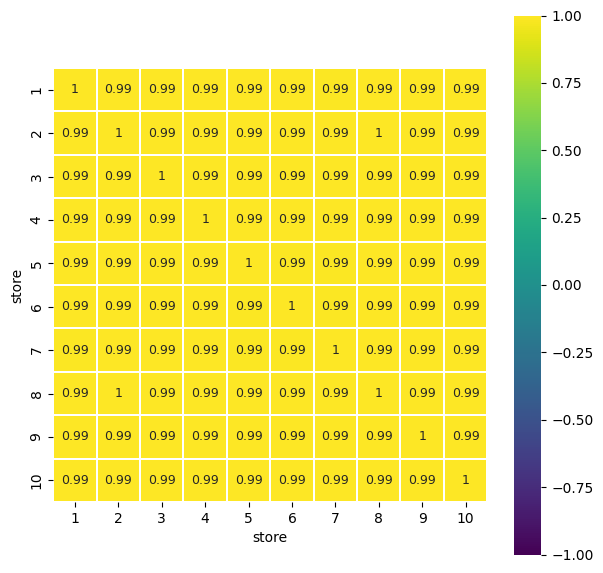

In [123]:
storesales = train.groupby(['date', 'store']).sales.sum().reset_index().set_index('date')
corr = pd.pivot_table(storesales, values = 'sales', columns='store', index = 'date').corr(method='pearson')

plt.figure(figsize=(7,7))
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.5)],
            cmap = 'viridis', vmax = 1.0, vmin = -1.0, linewidths = 0.1,
            annot = True, annot_kws = {'size': 9}, square = True)


# Hypothesis testing

In [5]:
# T test


int